In [79]:
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from transform_factory import get_trivial_augment, resize_224, center_crop_224, resize_322, imagenet_normalize, tensorize
from expl import ExplFactory
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np

import torch

In [58]:
model = resnet50(weights = ResNet50_Weights.DEFAULT).eval().cuda()
img = Image.open("/home/juhyeon/Imagenet/val/n04127249/ILSVRC2012_val_00024718.JPEG")
expl_func = ExplFactory().get_explainer(model = model, expl_method = "GradCAM", upsample=False)


In [59]:
orig_img = center_crop_224(resize_322(img))
expl_img = resize_224(img)


In [60]:
y = model(imagenet_normalize(tensorize(orig_img)).unsqueeze(0).cuda()).argmax()

In [61]:
orig_expl, _ = expl_func(imagenet_normalize(tensorize(orig_img)).unsqueeze(0).cuda(), y)

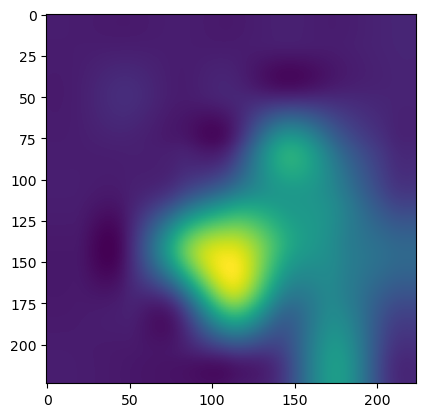

In [62]:
plt.imshow(F.interpolate(orig_expl, (224, 224), mode='bicubic').squeeze().detach().cpu())

In [63]:
T = get_trivial_augment()
trans_img = T(expl_img)

[('hflip', 1), ('Brightness', -0.296999990940094), ('Solarize', 212.5), ('Equalize', 0.0)]


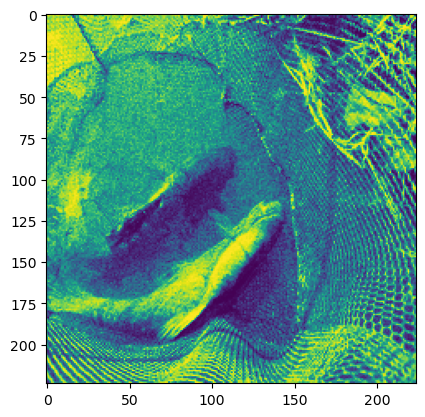

In [64]:
plt.imshow(trans_img.sum(0))
expl, pred = expl_func(trans_img.unsqueeze(0).cuda(), y)

In [65]:
_expl = center_crop_224(F.interpolate(expl, (322, 322), mode='bicubic'))
print(pred)

AttributeError: 'NoneType' object has no attribute 'dim'

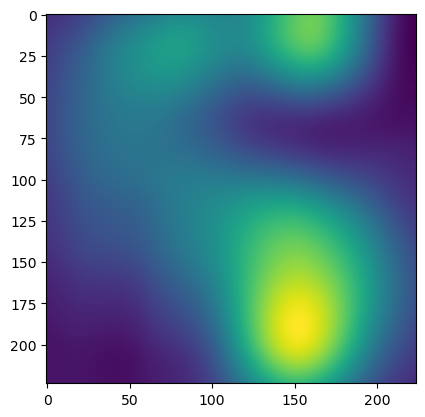

In [66]:
plt.imshow(_expl.squeeze().detach().cpu())

In [56]:
T_inv_spatial = transforms.Compose([
    transforms.RandomRotation((4.5, 4.5), InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(1),
    
])

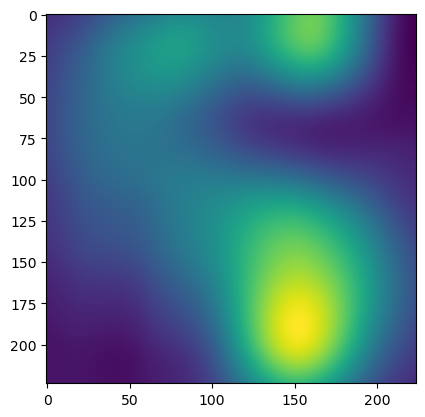

In [57]:
_expl = center_crop_224(T_inv_spatial(F.interpolate(expl, (322, 322), mode='bicubic')))
# _expl = center_crop_224(F.interpolate(expl, (322, 322), mode='bicubic'))




plt.imshow(_expl.squeeze().detach().cpu())

In [84]:
expr_path = "results/val_seed_0_dataset_center_crop_224_orig_input_method_center_crop_224_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00024718.JPEG_expl_GradCAM_sample_2000_sigma_0.05_seed_0_orig_true_config.npy" 
config_path = f"results/val_seed_0_dataset_center_crop_224_orig_input_method_center_crop_224_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00024718.JPEG_expl_GradCAM_sample_2000_sigma_0.05_seed_0_transform_config.txt" 


In [86]:
with open(expr_path, "rb") as f:
    orig_expl = np.load(f, allow_pickle=True)
    true_expls = np.load(f, allow_pickle=True)
    # configs = np.load(f, allow_pickle=True)

with open(config_path, "r") as f:
    configs = f.readlines()

In [75]:
true_expls.shape

(2000, 1, 7, 7)

In [108]:
indicies = np.arange(0, 2000, 1)
np.random.shuffle(indicies)
cal_idx, val_idx = indicies[:1000], indicies[1000:]

configs = np.array(configs)

KeyboardInterrupt: 

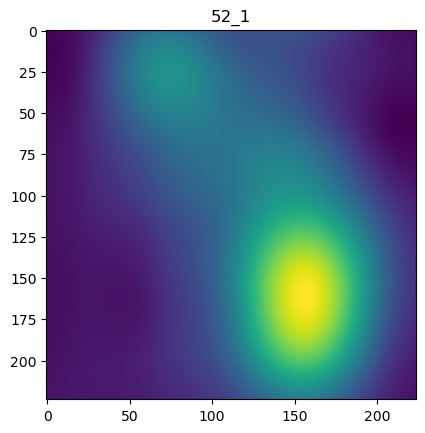

In [143]:
idx = 0
for true_expl, config in zip(true_expls[cal_idx], configs[cal_idx]):
    config = dict(eval(config))

    if 'Rotate' in config.keys():
        T_inv_spatial = transforms.Compose([
            transforms.RandomRotation((-config['Rotate'], -config['Rotate']), InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(config['hflip']),
            
        ])
    else:
        T_inv_spatial = transforms.Compose([
            transforms.RandomHorizontalFlip(config['hflip']),
        ])

    true_expl = center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expl).cuda().unsqueeze(0), (322, 322), mode='bicubic'))).squeeze(0)

    plt.imshow(true_expl.squeeze().detach().cpu())

    if 'Rotate' in config.keys():
        plt.title(f"{idx}_{config['hflip']}_{config['Rotate']}")
    else:
        plt.title(f"{idx}_{config['hflip']}")
    plt.savefig("./true_expl.jpeg")
    idx += 1
    


[('hflip', 1), ('Rotate', -85.5), ('Brightness', 0.8910000324249268), ('Posterize', 6.0), ('Solarize', 229.5), ('AutoContrast', 0.0), ('Equalize', 0.0)]



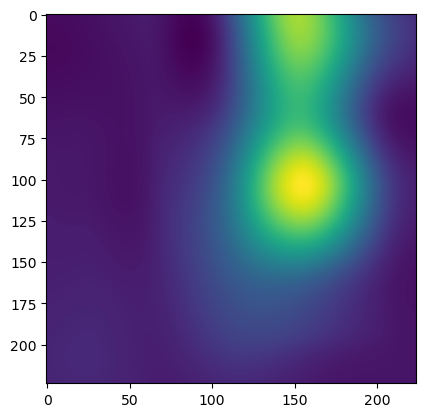

In [194]:
data_idx = 142

true_expl = center_crop_224(F.interpolate(torch.tensor(true_expls[cal_idx[data_idx]]).cuda().unsqueeze(0), (322, 322), mode='bicubic')).squeeze(0)
config = configs[cal_idx[data_idx]]
print(config)

config = dict(eval(config))
if 'Rotate' in config.keys():
    T_inv_spatial = transforms.Compose([
        transforms.RandomRotation((-config['Rotate'], -config['Rotate']), InterpolationMode.BILINEAR),

        transforms.RandomHorizontalFlip(config['hflip']),
        
    ])
else:
    T_inv_spatial = transforms.Compose([
        transforms.RandomHorizontalFlip(config['hflip']),
    ])
# plt.imshow(true_expl.squeeze().detach().cpu())

true_expl = center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expls[cal_idx[data_idx]]).cuda().unsqueeze(0), (322, 322), mode='bicubic'))).squeeze(0)
plt.imshow(true_expl.squeeze().detach().cpu())
